In [1]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import keras
from keras import initializers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from keras.constraints import max_norm
from scipy.stats import pearsonr
from scipy.stats import uniform

from time import time
import math

import random
from scipy.misc import comb

import scipy.stats as ss

Using TensorFlow backend.


In [2]:
### TUNING PARAMETERS ###

observations = 5999                    # Sample construction
X_val_size = 999
n_split = 5
                      
N_nodes = [1, 2, 3]                    # Design MLP                       
t=0
H_layers = [1, 2, 3, 4, 5, 10, 25, 50, 100]

m = 0                                  # Distribution parameters
sd = 1               
alpha = 0.5
beta = 0.5
lambd = 1.5
a = 0.25
b = 0.75

                                       # Grid search hyperparameters
batch_size = [50, 100, 500, 1000]
epochs = [500, 1000, 5000]

dropout_rate = [0.1, 0.3, 0.5]
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3, 0.5]
weight_constraint = [0, 3, 5]

neurons = [1, 2, 3, 4, 5, 10, 25, 50, 100]
                                       #grid_search or random_search?
search = "random_search"
n_iter_search = 10

t_size = 0.4

### HYPERPARAMETERS Mixed N ###
# Parameters of the mixture components
norm_params = np.array([[0.1, 0.1], [0.6, 0.1]])
n_components = norm_params.shape[0]
# Weight of each component, in this case all of them are 1/3
weights = np.ones(n_components, dtype=np.float64) / n_components

In [3]:
### FUNCTIONS ###

def create_dataset():
    #x = np.array([[random.gauss(m, sd) for i in range(N_nodes[t])] for i in range(0, observations+1)])
    #y = np.array([0.95*i/observations+0.05 for i in range(0,observations+1)])
    
    # A stream of indices from which to choose the component
    mixture_idx = np.array([np.random.choice(len(weights), size=N_nodes[t], replace=True, p=weights) for i in range(observations+1)])
    # mix_sample is the mixture sample
    mix_sample = np.array([np.fromiter((ss.uniform.rvs(*(norm_params[i])) for i in mixture_idx[:,j]), dtype=np.float64) for j in range(N_nodes[t])])

    # Theoretical PDF plotting -- generate the x and y plotting positions
    x = np.sort(mix_sample, 1)
    x = np.matrix.transpose(x)
    
    #check dimensionality
    print('dimensionality of x :', np.shape(x))
    #print('dimensionality of y: ', np.shape(y))
    
    #sort
    #x_sorted = np.sort(x,0)

    #correlation
    #for i in range(N_nodes[t]):
    #    print("correlation for " +str(N_nodes[t])+ ": ",pearsonr(x_sorted[:,0], y))
    
    print('\n')
    #return (x_sorted, y)
    return x

def create_targetset(x):
    #x = np.array([[random.gauss(m, sd) for i in range(N_nodes[t])] for i in range(0, observations+1)])
    #y = np.array([0.95*i/observations+0.05 for i in range(0,observations+1)])
    #y = np.sort(np.array([random.uniform(0,1) for i in range(0,observations+1)]))
    
    y_temp = np.zeros([observations+1, N_nodes[t]])

    for i in range(N_nodes[t]):
        for (l, s), w in zip(norm_params, weights):
            #y_temp[:,i] += ss.norm.pdf(np.array([x[i,:][j][0] for j in range(observations+1)]), loc=l, scale=s) * w
            y_temp[:,i] += ss.uniform.pdf(x[:,i], loc=l, scale=s) * w

    #index = np.arange(observations+1)
    #y_temp = np.array([y_temp[index[i]] for i in range(len(index))])
    y = np.array([[(y_temp[:,j][i]+sum(y_temp[:,j][0:i]))/sum(y_temp[:,j]) for i in range(0,(observations+1))] for j in range(N_nodes[t])])
    y = np.matrix.transpose(y)
    y_temp = np.matrix.transpose(y_temp)

    #check dimensionality
    #print('dimensionality of x :', np.shape(x))
    print('dimensionality of y: ', np.shape(y))
    
    #sort
    #x_sorted = np.sort(x,0)

    #correlation
    #for i in range(N_nodes[t]):
    #    print("correlation for " +str(N_nodes[t])+ ": ",pearsonr(x_sorted[:,0], y))
    
    print('\n')
    #return (x_sorted, y)
    return (y_temp, y)

def scale(x):
    ### scale ###
    mean = np.mean(x, axis=0)
    var = np.var(x, axis=0)
    print("mean is: ", mean)
    print("variance is: ", var)

    x_scaled = np.array([(i-mean)/np.sqrt(var) for i in x])
    
    print('\n')
    return x_scaled


def plot_dataset(x, y):
    
    for i in range(N_nodes[t]):
        plt.scatter(x[:,i], y[:,i], c=y)
        plt.ylabel('Cumulative Probability < RV value')
        plt.xlabel('Random Variable (RV) value')
        #plt.plot(x[:,i], y[:,i], label="actual CDF")
        plt.colorbar(ticks=np.linspace(min(y[:,i]), max(y[:,i]), 10, endpoint=True))
        plt.savefig('ToymodelNNA Mixed Uniform('+str(norm_params)+') plot_dataset obs'+str(observations+1)+': N'+str(i)+'.png')
        plt.show()
    

def plot_cdf(X_train, Y_train, X_test, Y_test, X_train_scaled, X_test_scaled, predictions):
        for i in range(N_nodes[t]):
            plt.scatter(X_test[:,i], Y_test, label='test set')
            plt.scatter(X_test[:,i], predictions, label='fitted set')
            #plt.scatter(X_test[:,i], norm.cdf(X_test[:,i]), label="actual CDF")
            plt.ylabel('Cumulative Probability < RV value')
            plt.xlabel('Random Variable (RV) value')
            plt.legend()
            plt.show()

def plot_est_cdf(X_train, Y_train, X_test, Y_test, X_train_scaled, X_test_scaled, predictions):
        for i in range(N_nodes[t]):
            plt.scatter(X_test[:,i], Y_test, label='test set')
            plt.scatter(X_test[:,i], predictions, label='fitted set')
            #plt.scatter(X_test[:,i], norm.cdf(X_test[:,i]), label="actual CDF")
            plt.ylabel('Cumulative Probability < RV value')
            plt.xlabel('Random Variable (RV) value')
            plt.legend()
            plt.savefig('ToymodelNNA Mixed Uniform('+str(norm_params)+') plot_cdf hyperparameters H_layers'+str(dict_H_layers[np.argmin(best_score)])+', neurons'+str(dict_neurons[np.argmin(best_score)])+', epochs'+str(dict_epochs[np.argmin(best_score)])+', batch_size'+str(dict_batch_size[np.argmin(best_score)])+', learn_rate'+str(dict_learn_rate[np.argmin(best_score)])+'weight_constraint'+str(dict_weight_constraint[np.argmin(best_score)])+': N'+str(i)+'.png')
            plt.show()
        
def create_model(H_layers=1, optimizer='Adam', init=initializers.RandomNormal(mean=0, stddev=0.25, seed=None), activation='sigmoid', dropout_rate=0.0, learn_rate=0.01, neurons=1, weight_constraint=0):
#def create_model(optimizer, init, dropout_rate, learn_rate, activation, neurons, weight_constraint):
    ### CREATE MODEL ###
    MLP = Sequential()
    #MLP.add(Dropout(dropout_rate, input_shape=(N_nodes[t],)))
    MLP.add(Dense(neurons, input_dim=N_nodes[t], kernel_initializer=init, activation=activation, kernel_constraint=max_norm(weight_constraint)))    #hidden layer
    #MLP.add(Dropout(dropout_rate))
    for h in range(1,H_layers):                                                                     #multiple hidden layers
        MLP.add(Dense(neurons, kernel_initializer=init, activation=activation, kernel_constraint=max_norm(weight_constraint)))
        #MLP.add(Dropout(dropout_rate))
    #MLP.add(Dense(1, kernel_initializer=init, activation='sigmoid'))                                 #output layer
    MLP.add(Dense(1, kernel_initializer=init))
    MLP.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    return MLP

def train_ANN(search, X_train, Y_train, X_test):
    
    model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model, verbose=0)
    print('Keras wrapper done')
    param = dict(epochs=epochs, batch_size=batch_size, neurons=neurons, H_layers=H_layers, learn_rate=learn_rate, weight_constraint=weight_constraint)
    #param = dict(neurons=neurons, H_layers=H_layers, learn_rate=learn_rate, weight_constraint=weight_constraint)
    
    if (search == 'random_search'):
        print('RANDOM SEARCH')
        grid = RandomizedSearchCV(estimator=model, param_distributions=param, n_iter=n_iter_search, n_jobs=1)
        print('Grid is prepared')
        start = time()
        grid.fit(X_train, Y_train)
        #grid.fit(X_train, Y_train, batch_size=500, epochs=1000)
        print("RandomizedSearchCV took %.2f seconds for %d candidates"
              " parameter settings." % ((time() - start), n_iter_search))
    else:
        print('GRIDSEARCH')
        grid = GridSearchCV(estimator=model, param_grid=param, n_jobs=1)
        print('Grid is prepared')
        start = time()
        grid.fit(X_train, Y_train)
        #grid.fit(X_train, Y_train, batch_size=500, epochs=1000)
        print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
              % (time() - start, len(grid.cv_results_['params'])))

    # summarize results (smallest loss?)
    print("Best: %f using %s" % (-grid.best_score_, grid.best_params_))
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    params = grid.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (-mean, stdev, param))
    
    predictions = grid.best_estimator_.predict(X_test)
    
    print('\n')
    return (grid, predictions)

def run_ANN(X_train, Y_train, X_test):
    
    model = create_model(H_layers=H_layers, learn_rate=learn_rate, neurons=neurons, weight_constraint=weight_constraint)
    print('Keras wrapper done')
    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae'])
    model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        
    predictions = model.predict(X_test)
    
    print('\n')
    return (model, predictions)

def activation_function(x):
    return 1/(1+math.exp(-x))

### CHECK PROCEDURE ON TEST SET ###

def run_ANN_manually(X_val, X_val_scaled):
    #assuming biases are included
    b = 0
    k = 0
    #print('k', k)
    temp_saved = np.zeros([len(X_val_scaled), H_layers+1, neurons])
    predictions = np.zeros([len(X_val_scaled)])
    #print('temp_saved', temp_saved)
    while (H_layers-k)>=0:
        #print('while (H_layers-k)>=0:' ,H_layers-k)
        if (k==0):
            #print('k==0')
            for i in range(len(X_val_scaled)):
                #print('i', i)
                for j in range(neurons):
                    #print('j', j)
                    for l in range(N_nodes[t]):
                        #print('l', l)
                        temp_saved[i][k][j] += X_val_scaled[i][l]*weights[b][l][j]
                        #print('temp_saved', temp_saved)
                    temp_saved[i][k][j] += 1*weights[b+1][j]
                    #print('temp_saved', temp_saved)
                    temp_saved[i][k][j] = activation_function(temp_saved[i][k][j])
            #print('temp_saved', temp_saved)
            b += 2
            k += 1
        elif((H_layers-k)>0 and k!=0):
            #print('(H_layers-k)>0 and k!=0')
            #print('k', k)
            for i in range(len(X_val_scaled)):
                #print('i', i)
                for j in range(neurons):
                    #print('j', j)
                    for l in range(neurons):
                        #print('l', l)
                        temp_saved[i][k][j] += temp_saved[i][k-1][l]*weights[b][l][j]
                        #print('temp_saved', temp_saved)
                    temp_saved[i][k][j] += 1*weights[b+1][j]
                    #print('1*weights[k+2][j]', 1*weights[k+2][j])
                    #print('temp_saved', temp_saved)
                    temp_saved[i][k][j] = activation_function(temp_saved[i][k][j])
            #print('temp_saved', temp_saved)
            b += 2
            k += 1
        elif(H_layers-k)==0:
            #print('(H_layers-k)==0')
            #print('k', k)
            for i in range(len(X_val_scaled)):
                #print('i', i)
                for l in range(neurons):
                    #print('l', l)
                    temp_saved[i][k][0] += temp_saved[i][k-1][l]*weights[b][l][0]
                    predictions[i] += temp_saved[i][k-1][l]*weights[b][l][0]
                    #print('temp_saved', temp_saved)
                temp_saved[i][k][0] += 1*weights[b+1][0]
                predictions[i] += 1*weights[b+1][0]
                #print('temp_saved', temp_saved)
                #temp_saved[i][k][0] = activation_function(temp_saved[i][k][0])
                #predictions[i] = activation_function(predictions[i])
            #print('temp_saved', temp_saved)
            k += 1                                                     #stop while-loop

    plot_cdf(X_test, Y_test, X_val, Y_val, X_test_scaled, X_val_scaled, predictions)

    return (temp_saved, predictions)

def derivative_sigmoid(x):
    return 1/(1+math.exp(-x))*(1-1/(1+math.exp(-x)))

def derivative_revised(): 
    #i = len(temp_saved[0])-1
    triangle = H_layers -2
    heart = len(weights)-2
    print('iterator temp_saved triangle: ', triangle, 'iterator weights heart: ', heart)

    #temp_layers (neurons middle layers)
    if H_layers > 1:
        print('STEP LAYERS')
        saved_layers = dict()
        for q in range(0, (H_layers-1)):
            print('NEW LAYER')
            print('q', q)
            saved_layers[q] = np.zeros([len(predictions), neurons])
            if(q==0):
                #print('IF')
                for obs in range(len(predictions)):
                    #print('NEW OBS')
                    #print('obs', obs)
                    for j in range(neurons):
                        #print('j', j)
                        temp_layers = 0
                        for k in range(neurons):
                            #print('k', k)
                            temp_sum = 0
                            for p in range(neurons):
                                #print('p', p)
                                #print('+temp_saved[obs][triangle][p]', 'temp_saved[obs][',triangle,'][',p,']')
                                #print('*weights[heart-2][p][k]', 'weights[',heart-2,'][',p,'][',k,']')
                                temp_sum += temp_saved[obs][triangle][p]*weights[heart-2][p][k]
                            #print('+weights[heart-1][k]', 'weights[',heart-1,'][',k,']')
                            temp_sum += weights[heart-1][k]
                            #print('----')
                            #print('weights[heart][k][0]', 'weights[',heart,'][',k,'][0]')
                            #print('weights[heart-2][j][k]', 'weights[',heart-2,'][',j,'][',k,']')
                            temp_layers += weights[heart][k][0]*derivative_sigmoid(temp_sum)*weights[heart-2][j][k]
                        saved_layers[q][obs][j] = temp_layers
            else: 
                #print('ELSE')
                for obs in range(len(predictions)):
                    #print('NEW OBS')
                    #print('obs', obs)
                    for j in range(neurons):
                        #print('j', j)
                        temp_layers = 0
                        for k in range(neurons):
                            #print('k', k)
                            temp_sum = 0
                            for p in range(neurons):
                                #print('p', p)
                                #print('+temp_saved[obs][triangle][p]', 'temp_saved[obs][',triangle,'][',p,']')
                                #print('*weights[heart-2][p][k]', 'weights[',heart-2,'][',p,'][',k,']')
                                temp_sum += temp_saved[obs][triangle][p]*weights[heart-2][p][k]
                            #print('+weights[heart-1][k]', 'weights[',heart-1,'][',k,']')
                            temp_sum += weights[heart-1][k]
                            #print('----')
                            #print('weights[heart][k][0]', 'weights[',heart,'][',k,'][0]')
                            #print('weights[heart-2][j][k]', 'weights[',heart-2,'][',j,'][',k,']')
                            temp_layers += saved_layers[q-1][obs][k]*derivative_sigmoid(temp_sum)*weights[heart-2][j][k]
                        saved_layers[q][obs][j] = temp_layers
            heart -= 2
            triangle -= 1

    print('iterator temp_saved triangle: ', triangle, 'iterator weights heart: ', heart)

    #derivative input layer
    print('LAST STEP')
    saved_last = np.zeros([len(predictions), N_nodes[t]])
    for obs in range(len(predictions)):
        #print('NEW OBS')
        #print('obs', obs)
        for i in range(N_nodes[t]):
            #print('i', i)
            temp_last = 0
            if (H_layers == 1):
                #print('IF')
                for k in range(neurons):
                    #print('k', k)
                    temp_sum = 0
                    for p in range(N_nodes[t]):
                        #print('p', p)
                        #print('weights[0][p][k]', 'weights[0][',p,'][',k,']')
                        #print('X_val[obs][p]', 'X_val[obs][',p,']')
                        temp_sum += weights[0][p][k]*X_val_scaled[obs][p]
                    #print('BIAS weights[1][k]', 'weights[1][',k,']')
                    temp_sum += weights[1][k]
                    #print('derivative_sigmoid')
                    #print('weights[2][k][0]', 'weights[2][',k,'][0]')
                    #print('weights[0][i][k]', 'weights[0][',i,'][',k,']')
                    temp_last += weights[2][k][0]*derivative_sigmoid(temp_sum)*weights[0][i][k]
                    #print('temp_last', temp_last)
                #print('saved_last[obs][i]', 'saved_last[obs][',i,']')
                saved_last[obs][i] = temp_last       
            else:
                #print('ELSE')
                for k in range(neurons):
                    #print('k', k)
                    temp_sum = 0
                    for p in range(N_nodes[t]):
                        #print('p', p)
                        #print('weights[0][p][k]', 'weights[0][',p,'][',k,']')
                        #print('X_val_scaled[obs][p]', 'X_val_scaled[obs][',p,']')
                        temp_sum += weights[0][p][k]*X_val_scaled[obs][p]
                    #print('BIAS weights[1][k]', 'weights[1][',k,']') 
                    temp_sum += weights[1][k]
                    #print('derivative_sigmoid')
                    #print('saved_layers[H_layers-2][obs][k]', 'saved_layers[',H_layers-2,'][obs][',k,']')
                    #print('weights[0][i][k]', 'weights[0][',i,'][',k,']')
                    temp_last += saved_layers[H_layers-2][obs][k]*derivative_sigmoid(temp_sum)*weights[0][i][k]
                saved_last[obs][i] = temp_last 

    return saved_last

dimensionality of x : (600, 1)


Simulations
dimensionality of y:  (600, 1)




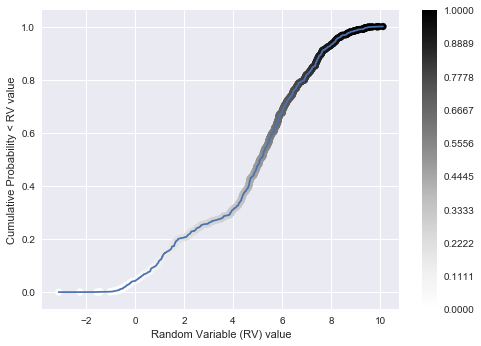

dimensionality of X_val: 	 (100, 1)
dimensionality of Y_val: 	 (100, 1)
dimensionality of x : 		 (500, 1)
dimensionality of y: 		 (500, 1) 

1 : TRAIN:  400 TEST:  100
X_train sample: 400 Y_train sample: 400
first entry of sample X_test [-2.25047037] first entry of sample Y_test [  8.82482190e-05] 

X_train scaling:
mean is:  [ 4.33398012]
variance is:  [ 8.33141039]


X_test scaling:
mean is:  [ 4.78187206]
variance is:  [ 7.65445582]


MLP created
Keras wrapper done
RANDOM SEARCH
Grid is prepared
RandomizedSearchCV took 571.87 seconds for 10 candidates parameter settings.
Best: 0.007014 using {'weight_constraint': 5, 'neurons': 2, 'learn_rate': 0.1, 'epochs': 1000, 'batch_size': 25, 'H_layers': 1}
0.103415 (0.084191) with: {'weight_constraint': 5, 'neurons': 20, 'learn_rate': 0.2, 'epochs': 100, 'batch_size': 50, 'H_layers': 3}
0.212745 (0.140870) with: {'weight_constraint': 0, 'neurons': 4, 'learn_rate': 0.01, 'epochs': 100, 'batch_size': 25, 'H_layers': 1}
0.218375 (0.144079) with:

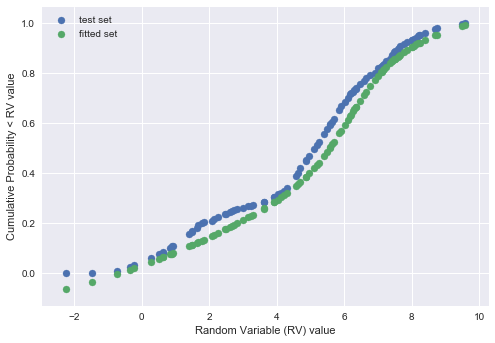

dimensionality of y:  (600, 1)




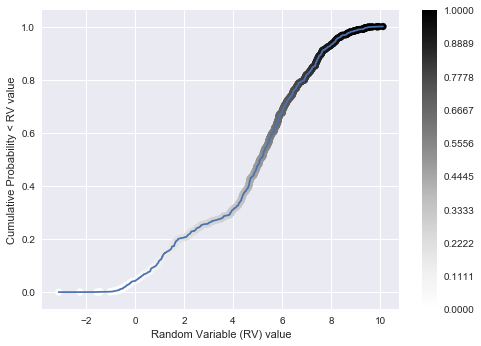

dimensionality of X_val: 	 (100, 1)
dimensionality of Y_val: 	 (100, 1)
dimensionality of x : 		 (500, 1)
dimensionality of y: 		 (500, 1) 

2 : TRAIN:  400 TEST:  100
X_train sample: 400 Y_train sample: 400
first entry of sample X_test [-0.88384578] first entry of sample Y_test [ 0.0032223] 

X_train scaling:
mean is:  [ 4.29046051]
variance is:  [ 8.65692175]


X_test scaling:
mean is:  [ 4.53756164]
variance is:  [ 7.55897192]


MLP created
Keras wrapper done
RANDOM SEARCH
Grid is prepared
RandomizedSearchCV took 620.80 seconds for 10 candidates parameter settings.
Best: 0.005050 using {'weight_constraint': 5, 'neurons': 5, 'learn_rate': 0.01, 'epochs': 500, 'batch_size': 25, 'H_layers': 2}
0.018910 (0.007019) with: {'weight_constraint': 3, 'neurons': 20, 'learn_rate': 0.1, 'epochs': 100, 'batch_size': 25, 'H_layers': 1}
0.224766 (0.146984) with: {'weight_constraint': 0, 'neurons': 5, 'learn_rate': 0.01, 'epochs': 100, 'batch_size': 50, 'H_layers': 5}
0.005050 (0.001652) with: {'wei

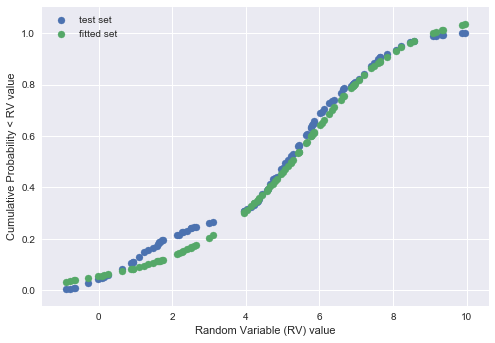

dimensionality of y:  (600, 1)




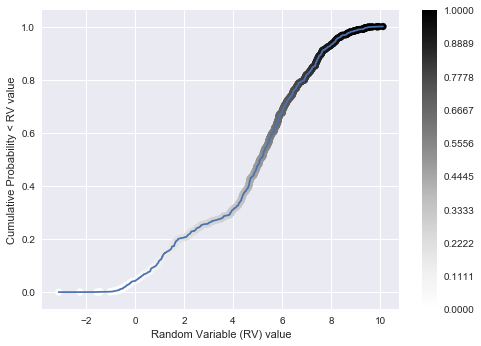

dimensionality of X_val: 	 (100, 1)
dimensionality of Y_val: 	 (100, 1)
dimensionality of x : 		 (500, 1)
dimensionality of y: 		 (500, 1) 

3 : TRAIN:  400 TEST:  100
X_train sample: 400 Y_train sample: 400
first entry of sample X_test [-3.11880249] first entry of sample Y_test [  1.15500480e-05] 

X_train scaling:
mean is:  [ 4.43375565]
variance is:  [ 8.37581695]


X_test scaling:
mean is:  [ 4.402683]
variance is:  [ 8.83861397]


MLP created
Keras wrapper done
RANDOM SEARCH
Grid is prepared
RandomizedSearchCV took 769.88 seconds for 10 candidates parameter settings.
Best: 0.004544 using {'weight_constraint': 3, 'neurons': 30, 'learn_rate': 0.1, 'epochs': 500, 'batch_size': 25, 'H_layers': 2}
0.222156 (0.143093) with: {'weight_constraint': 0, 'neurons': 4, 'learn_rate': 0.01, 'epochs': 100, 'batch_size': 25, 'H_layers': 3}
0.222155 (0.143276) with: {'weight_constraint': 5, 'neurons': 5, 'learn_rate': 0.01, 'epochs': 100, 'batch_size': 50, 'H_layers': 10}
0.004544 (0.002819) with: 

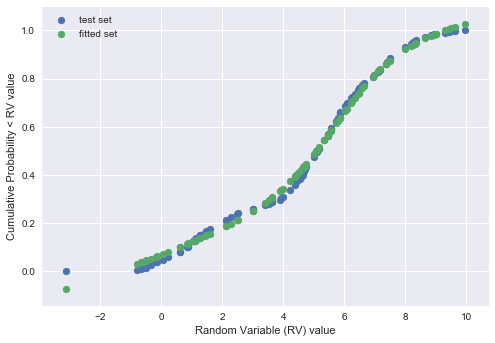

dimensionality of y:  (600, 1)




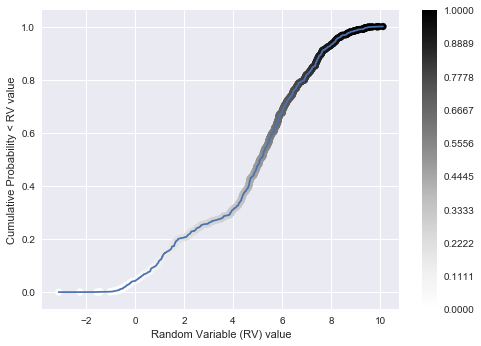

dimensionality of X_val: 	 (100, 1)
dimensionality of Y_val: 	 (100, 1)
dimensionality of x : 		 (500, 1)
dimensionality of y: 		 (500, 1) 

4 : TRAIN:  400 TEST:  100
X_train sample: 400 Y_train sample: 400
first entry of sample X_test [-1.42583006] first entry of sample Y_test [ 0.00093815] 

X_train scaling:
mean is:  [ 4.53548504]
variance is:  [ 7.87806705]


X_test scaling:
mean is:  [ 4.07352893]
variance is:  [ 7.69495452]


MLP created
Keras wrapper done
RANDOM SEARCH
Grid is prepared
RandomizedSearchCV took 1505.57 seconds for 10 candidates parameter settings.
Best: 0.005827 using {'weight_constraint': 5, 'neurons': 3, 'learn_rate': 0.01, 'epochs': 500, 'batch_size': 25, 'H_layers': 1}
0.005827 (0.002347) with: {'weight_constraint': 5, 'neurons': 3, 'learn_rate': 0.01, 'epochs': 500, 'batch_size': 25, 'H_layers': 1}
0.012464 (0.004156) with: {'weight_constraint': 3, 'neurons': 1, 'learn_rate': 0.01, 'epochs': 1000, 'batch_size': 25, 'H_layers': 3}
0.211154 (0.139360) with: {'

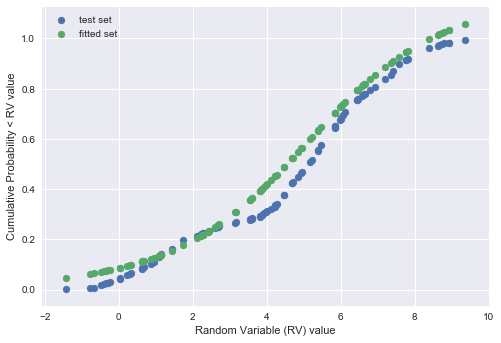

dimensionality of y:  (600, 1)




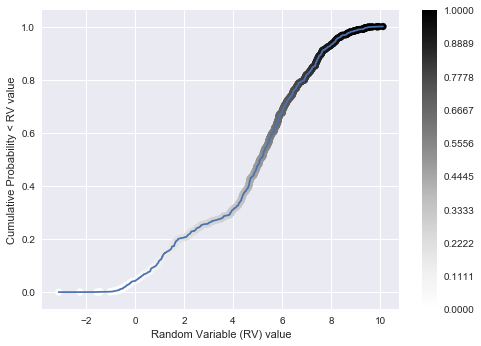

dimensionality of X_val: 	 (100, 1)
dimensionality of Y_val: 	 (100, 1)
dimensionality of x : 		 (500, 1)
dimensionality of y: 		 (500, 1) 

5 : TRAIN:  400 TEST:  100
X_train sample: 400 Y_train sample: 400
first entry of sample X_test [-1.42583006] first entry of sample Y_test [ 0.00093815] 

X_train scaling:
mean is:  [ 4.44627567]
variance is:  [ 8.21653468]


X_test scaling:
mean is:  [ 4.25565184]
variance is:  [ 9.46102534]


MLP created
Keras wrapper done
RANDOM SEARCH
Grid is prepared


KeyboardInterrupt: 

In [4]:
### K-FOLD SIMULATIONS ###

best_score = np.empty([n_split,])
dict_H_layers = np.empty([n_split,])
dict_learn_rate = np.empty([n_split,])
dict_neurons = np.empty([n_split,])
dict_weight_constraint = np.empty([n_split,])
dict_epochs = np.empty([n_split,])
dict_batch_size = np.empty([n_split,])
all_X_test_scaled = np.empty([n_split,int((observations+1-X_val_size-1)/n_split)])
all_predictions = np.empty([n_split,int((observations+1-X_val_size-1)/n_split)])

#create dataset
x_original = create_dataset()
index = np.random.choice(observations+1, X_val_size+1, replace=False)
    
X_val = x_original[index]
#Y_val = y[index]

x = np.delete(x_original, index, 0)
#y = np.delete(y, index, 0)

index_sort = np.argsort(X_val[:,0])
X_val = X_val[index_sort]
#Y_val = Y_val[index_sort]

#print('dimensionality of X_val: \t', np.shape(X_val))
#print('dimensionality of Y_val: \t', np.shape(Y_val))
#print('dimensionality of x : \t\t', np.shape(x))
#print('dimensionality of y: \t\t', np.shape(y), '\n')

kf = KFold(n_splits=n_split, shuffle=True, random_state=None)
kf.get_n_splits(x)
k = 1

print('Simulations')
M = 0
for train_index, test_index in kf.split(x):
    
    #y = np.sort(np.array([random.uniform(0,1) for i in range(0,observations+1)]))
    #y = np.array([0.95*i/observations+0.05 for i in range(0,observations+1)])
    y_pdf, y = create_targetset(x_original)
    plot_dataset(x_original, y)

    #take validation set out

    #X_val = x[0:(X_val_size+1)]
    #x = x[(X_val_size+1):(observations+1)]
    #Y_val = y[0:(X_val_size+1)]
    #y = y[(X_val_size+1):(observations+1)]

    #index = [random.randint(0,(observations+1)) for i in range(X_val_size+1)]
    index = np.random.choice(observations+1, X_val_size+1, replace=False)
    
    X_val = x_original[index]
    Y_val = y[index]

    x = np.delete(x_original, index, 0)
    y = np.delete(y, index, 0)

    index_sort = np.argsort(X_val[:,0])
    X_val = X_val[index_sort]
    Y_val = Y_val[index_sort]

    print('dimensionality of X_val: \t', np.shape(X_val))
    print('dimensionality of Y_val: \t', np.shape(Y_val))
    print('dimensionality of x : \t\t', np.shape(x))
    print('dimensionality of y: \t\t', np.shape(y), '\n')
    
    #create k-fold sets
    print(k, ':', 'TRAIN: ', len(train_index), 'TEST: ', len(test_index))
    #print('TRAIN: ', train_index, 'TEST: ', test_index)
    X_train, X_test = x[train_index], x[test_index]
    Y_train, Y_test = y[train_index], y[test_index]
    print('X_train sample:', len(X_train), 'Y_train sample:', len(Y_train))
    print('first entry of sample X_test', X_test[0], 'first entry of sample Y_test', Y_test[0], '\n')

    print('X_train scaling:')
    X_train_scaled = scale(X_train)
    print('X_test scaling:')
    X_test_scaled = scale(X_test)

    MLP = create_model()
    print('MLP created')
    grid, predictions = train_ANN(search, X_train_scaled, Y_train, X_test_scaled)
    plot_cdf(X_train, Y_train, X_test, Y_test, X_train_scaled, X_test_scaled, predictions)
    ###

    best_score[M] = -grid.best_score_
    dict_H_layers[M] = grid.best_params_['H_layers']
    dict_learn_rate[M] = grid.best_params_['learn_rate']
    dict_neurons[M] = grid.best_params_['neurons']
    dict_weight_constraint[M] = grid.best_params_['weight_constraint']
    dict_epochs[M] = grid.best_params_['epochs']
    dict_batch_size[M] = grid.best_params_['batch_size']
    all_predictions[M] = predictions
    all_X_test_scaled[M] = X_test_scaled[:,0]
    
    k += 1
    M += 1

In [ ]:
#choose structure for MLP
print("Best error score: ", np.amin(best_score), "\n")
print("Chosen structure: ", '{ weight_constraint: ',dict_weight_constraint[np.argmin(best_score)],', neurons: ', dict_neurons[np.argmin(best_score)], ', learn_rate', dict_learn_rate[np.argmin(best_score)], ', epochs: ', dict_epochs[np.argmin(best_score)], ', batch_size', dict_batch_size[np.argmin(best_score)], ', H_layers', dict_H_layers[np.argmin(best_score)],'}' )

# fix hyperparameters
weight_constraint = int(dict_weight_constraint[np.argmin(best_score)])
neurons = int(dict_neurons[np.argmin(best_score)])
learn_rate = dict_learn_rate[np.argmin(best_score)]
epochs = int(dict_epochs[np.argmin(best_score)])
batch_size = int(dict_batch_size[np.argmin(best_score)])
H_layers = int(dict_H_layers[np.argmin(best_score)])

#run on last test set ONLY (?)
model, predictions = run_ANN(X_train_scaled, Y_train, X_test_scaled)
plot_est_cdf(X_train, Y_train, X_test, Y_test, X_train_scaled, X_test_scaled, predictions)

#retrieve these weights
#(map weights MLP to validation set)
weights = model.get_weights()
print("length weights", len(weights))
for i in range(len(weights)):
    print("layers length: (weight + possible bias)", weights[i].size)

#print(model.get_weights())
#print(model.get_config())

### CHECK PROCEDURE ON TEST SET ###
temp_not_saved, Tpredictions = run_ANN_manually(X_test, X_test_scaled)
### WARNING (still small differences)
np.in1d(predictions,Tpredictions)
diff = predictions[:,0]-Tpredictions
print('differences between keras and self-constructed-procedure: \n', abs(diff))

### MAP TESTWEIGHTS ON VALSET ###
print('X_val scaling:')
X_val_scaled = scale(X_val)
temp_saved, predictions = run_ANN_manually(X_val, X_val_scaled)

In [ ]:
### DERIVATIVE H=? ###
outcome = derivative_revised()

for i in range(N_nodes[t]):
    #plt.scatter(X_val_scaled, temp_last[:,0], label="scaled fitted set")
    #plt.scatter(X_val_scaled, norm.pdf(X_test), label="scaled actual PDF")
    plt.scatter(X_val[:,i], outcome[:,i], label="fitted set")
    plt.scatter(X_val[:,i], y_pdf[:,i], label="actual PDF")
    plt.legend()
    plt.savefig('ToymodelNNA Mixed Uniform('+str(norm_params)+') plot_pdf: N'+str(i)+'.png')
    plt.show()

for i in range(N_nodes[t]):
    plt.scatter(X_val[:,i], outcome[:,i], label="fitted set")
    plt.legend()
    plt.show()
    

### NORMALIZATION ###

# Check PDF created by Python scipy.stats.norm and PDF created myself
y_check = np.array([[math.exp(-X_val[:,j][i]**2/2)/math.sqrt(2*math.pi) for i in range(len(X_val[:,0]))] for j in range(N_nodes[t])])

for i in range(N_nodes[t]):
    plt.plot(X_val[:,i], y_check[i,:])
    plt.scatter(X_val[:,i], outcome[:,i], label="fitted set")
    plt.scatter(X_val[:,i], y_pdf[:,i], label="actual PDF")
    plt.show()

sum_temp = np.zeros(N_nodes[t])
for j in range(N_nodes[t]):
    for i in range(len(X_val[:,j])-1):
        sum_temp[j] += ((y_check[j,:][i]+y_check[j,:][i+1])/2)*(X_val[:,j][i+1]-X_val[:,j][i])
print('area under the curve of scipy.stats.uniform.pdf \t', sum_temp)

sum_temp_fitted = np.zeros(N_nodes[t])
for j in range(N_nodes[t]):
    for i in range(len(X_val[:,j])-1):
        sum_temp_fitted[j] += ((outcome[:,j][i]+outcome[:,j][i+1])/2)*(X_val[:,j][i+1]-X_val[:,j][i])
print('area under the curve of the fitted pdf \t\t', sum_temp_fitted, '\n')

#normalization
new_uniformcdf = np.array([[x/sum_temp[j] for x in y_check[j,:]] for j in range(N_nodes[t])])
new_outcome = np.array([[x/sum_temp_fitted[j] for x in outcome[:,j]] for j in range(N_nodes[t])])

sum_temp = np.zeros(N_nodes[t])
for j in range(N_nodes[t]):
    for i in range(len(X_val[:,j])-1):
        sum_temp[j] += ((new_uniformcdf[j,:][i]+new_uniformcdf[j,:][i+1])/2)*(X_val[:,j][i+1]-X_val[:,j][i])
print('area under the curve of scipy.stats.uniform.pdf after normalization \t', sum_temp)

sum_temp_fitted = np.zeros(N_nodes[t])
for j in range(N_nodes[t]):
    for i in range(len(X_val[:,j])-1):
        sum_temp_fitted[j] += ((new_outcome[j,:][i]+new_outcome[j,:][i+1])/2)*(X_val[:,j][i+1]-X_val[:,j][i])
print('area under the curve of the fitted pdf after normalization \t\t', sum_temp_fitted)

for i in range(N_nodes[t]):
    plt.scatter(X_val[:,i], new_outcome[i,:], label="fitted set")
    plt.scatter(X_val[:,i], y_pdf[i,:], label="actual PDF")
    plt.legend()
    plt.savefig('ToymodelNNA Mixed Uniform('+str(norm_params)+') plot_normalized_pdf: N'+str(i)+'.png')
    plt.show()